# train.csv 데이터 구조 및 기초 탐색 (EDA)

이 노트북에서는 **대구 공공데이터 시각화 프로젝트**에서 사용되는  
`train.csv` 파일에 대해 다음 내용을 실습합니다.

1. `train.csv` 파일 로드 및 기본 확인  
2. 데이터프레임 상위 10행(`head(10)`) 출력  
3. 컬럼 정보 및 데이터 타입 확인  
4. **수치형 / 범주형 컬럼 분리**  
5. 수치형 컬럼에 대한 기초 통계량(`describe()`) 확인  
6. **모든 수치형 / 범주형 컬럼에 대한 히스토그램(또는 bar chart) 시각화**

이 노트북은 이후 Streamlit 프로젝트의 화면 구성을  
Colab에서 “미리 검증”하기 위한 용도입니다.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 50 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,561 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
matplotlibrc 경로: /usr/local/lib/p

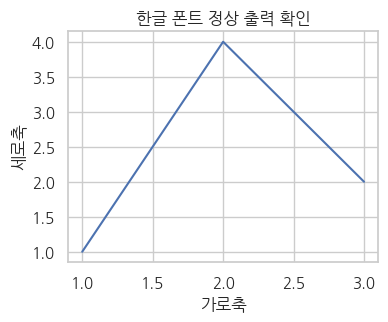

In [ ]:
# ==========================================
# 1. 한글 출력을 위한 기초 셀
#    (코랩에서 한 번만 실행하면 이후 그래프에 한글이 깨지지 않도록 설정)
#    참조: https://conding-note.tistory.com/335
# ==========================================

!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib as mpl
print("matplotlibrc 경로:", mpl.matplotlib_fname())

import shutil
import matplotlib as mpl

# matplotlib 설정 파일(matplotlibrc)의 경로에서 루트 디렉토리만 추출
# 예) /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/matplotlibrc
#  → /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/
root = mpl.matplotlib_fname().replace("matplotlibrc", "")

# matplotlib 기본 폰트 파일(DejaVuSans.ttf)이 위치한 경로
target_font = root + "fonts/ttf/DejaVuSans.ttf"
print("matplotlib 기본 폰트 파일:", target_font)

# 나눔고딕 폰트 경로 (Ubuntu/Colab에서 설치되는 경로)
nanum_font = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# DejaVuSans.ttf 파일을 나눔고딕으로 교체하여
# matplotlib의 기본 폰트를 나눔고딕으로 설정
shutil.copyfile(nanum_font, target_font)
print("기본 폰트를 나눔고딕으로 교체 완료")

# matplotlib 캐시 삭제 (새 폰트 강제 적용)
!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일을 'whitegrid'로 지정 (흰 배경 + 그리드)
sns.set(style="whitegrid")

# 테스트 플롯 (한글 출력 확인)
plt.figure(figsize=(4,3))
plt.title("한글 폰트 정상 출력 확인")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([1,2,3], [1,4,2])
plt.show()


In [ ]:
# ==========================================
# 2. 기본 라이브러리 임포트
# ==========================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 크기 및 폰트 기본 설정 (추가)
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지


## 3. train.csv 파일 로드

`train.csv`는 두 가지 방식 중 하나로 불러올 수 있습니다.

1. **Colab에서 직접 파일 업로드**  
2. 구글 드라이브에 올려두고 경로를 지정하여 로드  

이번 실습에서는 가장 간단한 **직접 업로드 방식**을 사용합니다.  
(교육 상황에 맞게 Drive 마운트 방식으로 바꿔도 됩니다.)


In [ ]:
# ==========================================
# 3. train.csv 업로드 및 로드
# ==========================================
from google.colab import files

print("train.csv 파일을 선택해서 업로드 해주세요.")
uploaded = files.upload()  # 파일 선택 창이 뜸

# 업로드된 파일 이름 확인
print("업로드된 파일 목록:", list(uploaded.keys()))

# 일반적으로 파일 이름이 'train.csv' 라고 가정
file_name = list(uploaded.keys())[0]  # 첫 번째 업로드 파일 사용
print("사용할 파일 이름:", file_name)

# 인코딩을 여러 개 시도하는 헬퍼 함수 정의
def read_csv_safe(path, encodings=["utf-8", "utf-8-sig", "cp949"]):
    """
    여러 인코딩을 시도하면서 CSV 파일을 안전하게 읽기 위한 함수.
    """
    last_error = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_error = e
            print(f"[경고] 인코딩 {enc} 로 읽기 실패: {e}")
            continue
    raise ValueError(f"CSV를 어떤 인코딩으로도 읽을 수 없습니다. 마지막 에러: {last_error}")

# 실제 데이터 로드
df = read_csv_safe(file_name)

print("데이터 로딩 완료!")
print("데이터 형태 (행, 열):", df.shape)


train.csv 파일을 선택해서 업로드 해주세요.


Saving train.csv to train.csv
업로드된 파일 목록: ['train.csv']
사용할 파일 이름: train.csv
[경고] 인코딩 utf-8 로 읽기 실패: 'utf-8' codec can't decode byte 0xbb in position 0: invalid start byte
[경고] 인코딩 utf-8-sig 로 읽기 실패: 'utf-8' codec can't decode byte 0xbb in position 3: invalid start byte
데이터 로딩 완료!
데이터 형태 (행, 열): (39609, 23)


In [ ]:
# ==========================================
# 4. 데이터 상위 10행 및 기본 정보 확인
# ==========================================

# 상위 10행 출력
print("=== train 데이터 상위 10행 (head(10)) ===")
display(df.head(10))

# info()로 컬럼 타입, 결측치 등 기본 정보 확인
print("\n=== 데이터 info() ===")
df.info()

# ==========================================
# 추가: 전체 행 수, 전체 컬럼 수, 평균 결측값 %
# ==========================================
print("\n=== train 데이터 기본 요약 ===")
total_rows = df.shape[0]
total_cols = df.shape[1]
missing_ratio = df.isnull().mean().mean() * 100  # 전체 결측 비율 %

print(f"전체 행 수: {total_rows:,}")
print(f"전체 컬럼 수: {total_cols:,}")
print(f"평균 결측값 비율: {missing_ratio:.2f}%")


=== train 데이터 상위 10행 (head(10)) ===


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
5,ACCIDENT_00005,2019-01-01 04,화요일,맑음,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,...,상해없음,승용,남,35세,경상,0,0,2,0,6
6,ACCIDENT_00006,2019-01-01 05,화요일,맑음,대구광역시 수성구 지산동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,경상,승용,남,76세,경상,0,0,6,0,18
7,ACCIDENT_00007,2019-01-01 06,화요일,흐림,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,53세,경상,0,0,1,0,3
8,ACCIDENT_00008,2019-01-01 06,화요일,맑음,대구광역시 북구 태전동,기타 - 기타,건조,차대차,기타,안전운전불이행,...,상해없음,자전거,남,62세,중상,0,1,0,0,5
9,ACCIDENT_00009,2019-01-01 10,화요일,맑음,대구광역시 동구 지묘동,단일로 - 터널,건조,차대차,기타,신호위반,...,상해없음,승용,여,42세,경상,0,0,3,0,9



=== 데이터 info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수 

## 5. 수치형 / 범주형 컬럼 분리하기

모델링이나 시각화를 할 때는  
**수치형 컬럼(numerical)**과 **범주형 컬럼(categorical)**을 나누어 보는 것이 중요합니다.

- 수치형: 평균, 표준편차, 히스토그램 등으로 분포 확인  
- 범주형: 값의 빈도수, bar chart 등으로 분포 확인  

여기서는 `pandas`의 `select_dtypes`를 활용하여  
자동으로 수치형 / 범주형 컬럼을 분리해 봅니다.


In [ ]:
# ==========================================
# 5. 수치형 / 범주형 컬럼 분리
# ==========================================

# 수치형 컬럼: int, float 계열
numeric_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

# 범주형 컬럼: object, category, bool 계열
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("=== 수치형 컬럼 목록 ===")
print(numeric_cols)

print("\n=== 범주형 컬럼 목록 ===")
print(categorical_cols)


=== 수치형 컬럼 목록 ===
['사망자수', '중상자수', '경상자수', '부상자수', 'ECLO']

=== 범주형 컬럼 목록 ===
['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도']


## 6. 수치형 컬럼의 기초 통계량 확인

수치형 컬럼에 대해 `df[numeric_cols].describe()`를 통해  
다음과 같은 기초 통계량을 확인합니다.

- count (데이터 개수)
- mean (평균)
- std (표준편차)
- min / max (최솟값 / 최댓값)
- 25%, 50%, 75% 분위수

이 정보만으로도 데이터의 대략적인 분포와 스케일을 파악할 수 있습니다.


In [ ]:
# ==========================================
# 6. 수치형 컬럼 기초 통계량
# ==========================================

if len(numeric_cols) > 0:
    print("=== 수치형 컬럼 기초 통계량 (describe) ===")
    display(df[numeric_cols].describe().T)  # 컬럼별로 보기 좋게 전치(T)
else:
    print("수치형 컬럼이 없습니다.")


=== 수치형 컬럼 기초 통계량 (describe) ===


,count,mean,std,min,25%,50%,75%,max
사망자수,39609.0,0.007776,0.090109,0.0,0.0,0.0,0.0,2.0
중상자수,39609.0,0.262365,0.500845,0.0,0.0,0.0,0.0,6.0
경상자수,39609.0,1.070085,0.992034,0.0,0.0,1.0,1.0,22.0
부상자수,39609.0,0.126865,0.394670,0.0,0.0,0.0,0.0,10.0
ECLO,39609.0,4.726704,3.207206,1.0,3.0,3.0,6.0,74.0


## 7. 모든 수치형 컬럼에 대한 히스토그램

이제 `numeric_cols`에 포함된 모든 컬럼에 대해  
**자동으로 히스토그램을 그려보겠습니다.**

- 각 컬럼별로 하나의 그래프
- 분포가 치우쳐 있는지, 이상치가 있는지, 값의 범위가 어떤지 직관적으로 확인 가능


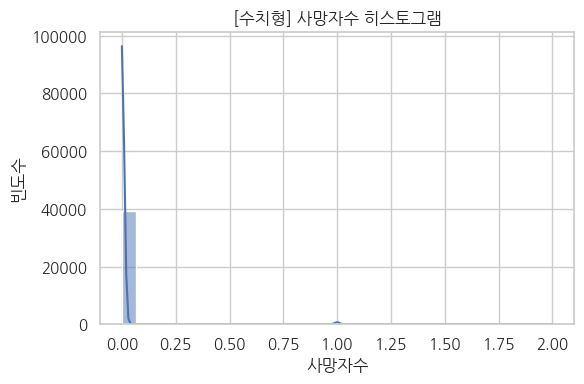

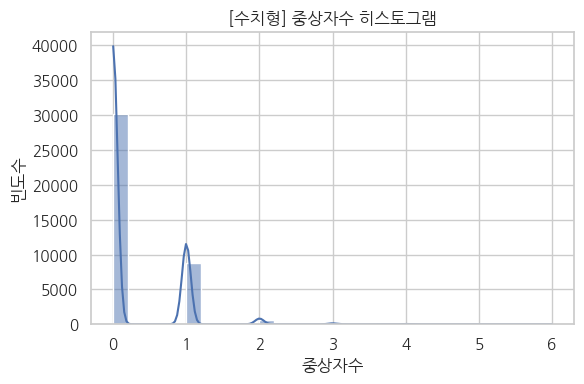

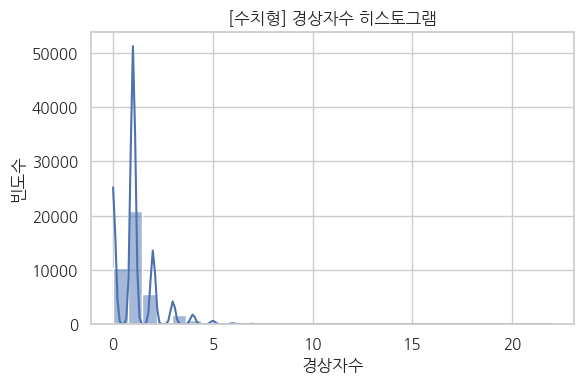

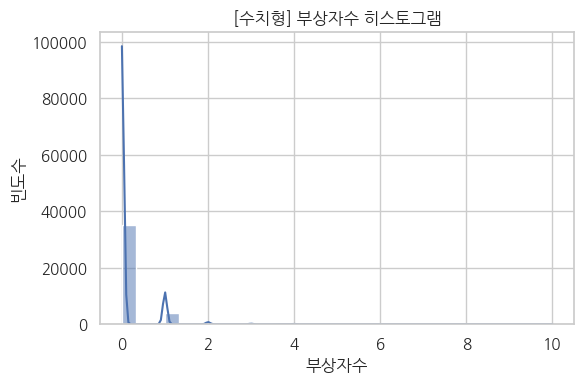

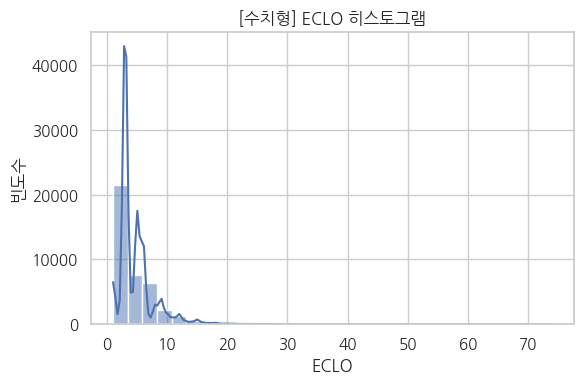

In [ ]:
# ==========================================
# 7. 모든 수치형 컬럼 히스토그램 그리기
# ==========================================

if len(numeric_cols) == 0:
    print("수치형 컬럼이 없어 히스토그램을 그릴 수 없습니다.")
else:
    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df, x=col, kde=True, bins=30)
        plt.title(f"[수치형] {col} 히스토그램")
        plt.xlabel(col)
        plt.ylabel("빈도수")
        plt.tight_layout()
        plt.show()


## 8. 모든 범주형 컬럼에 대한 bar chart

범주형 컬럼은 **각 값이 몇 번 등장하는지(빈도)**를 보는 것이 기본입니다.

- 범주 개수가 너무 많을 경우, 상위 N개까지만 시각화하는 것이 좋습니다.  
- 여기서는 기본으로 **상위 20개 카테고리**까지만 bar chart로 표시합니다.


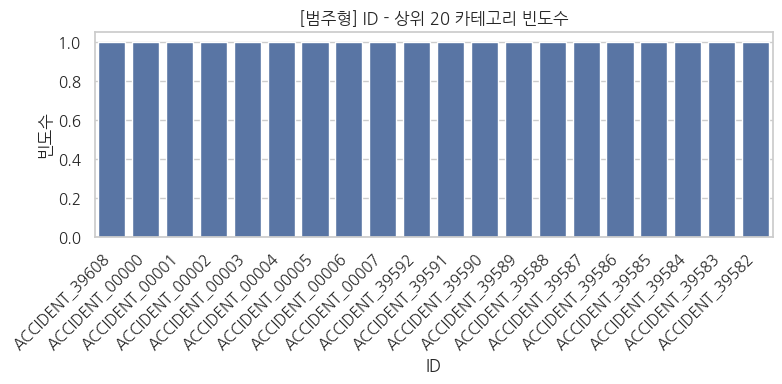

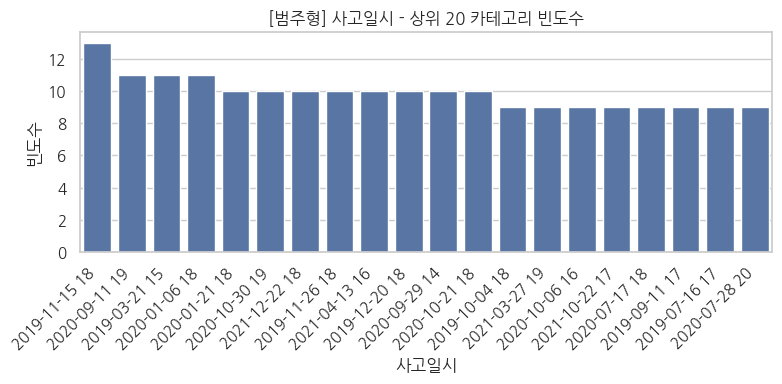

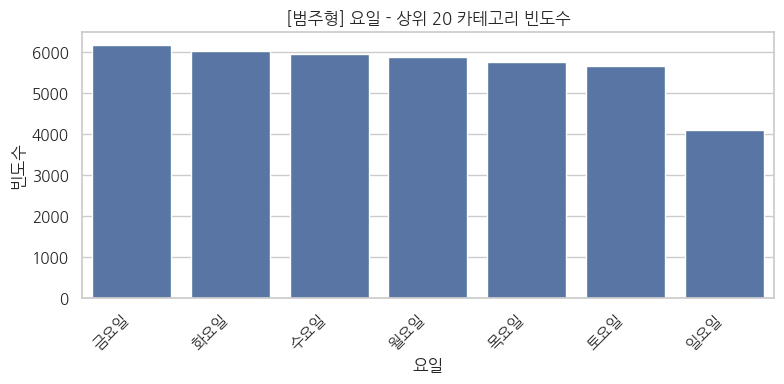

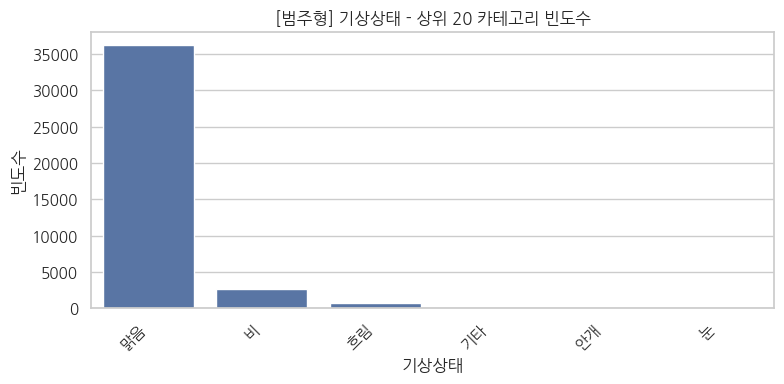

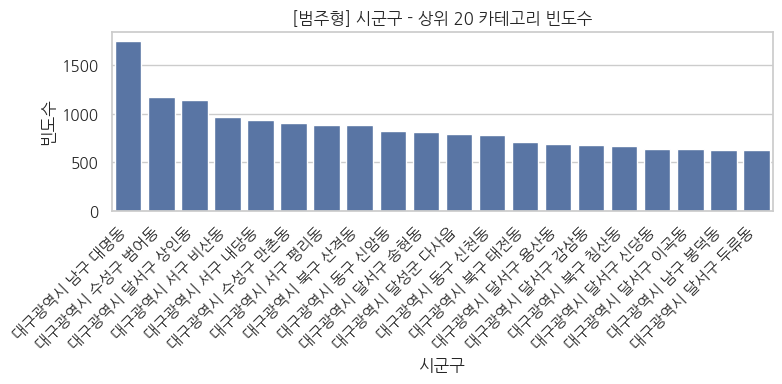

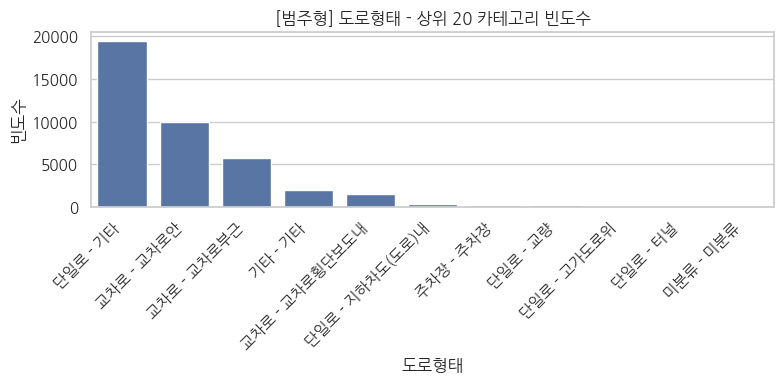

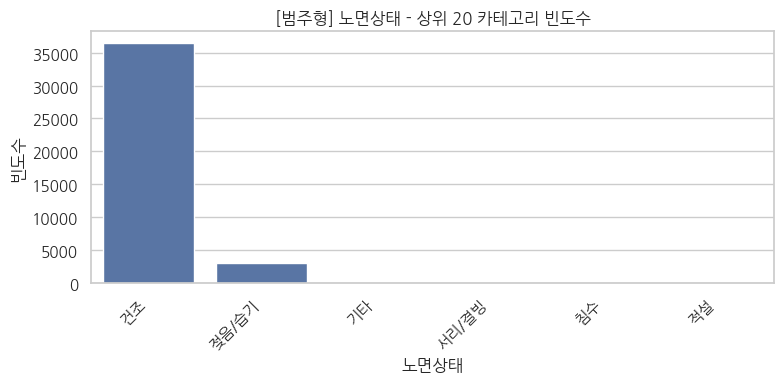

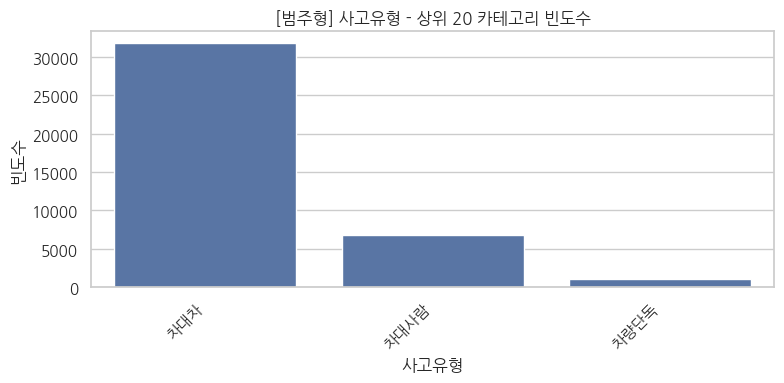

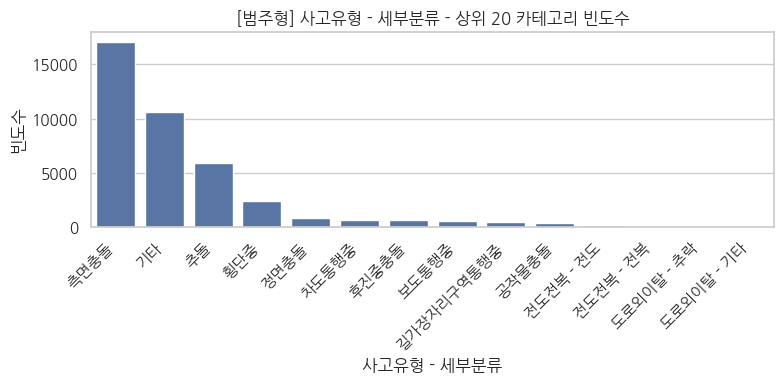

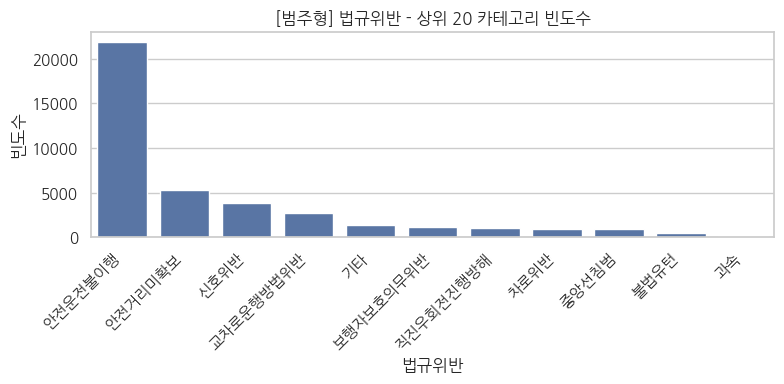

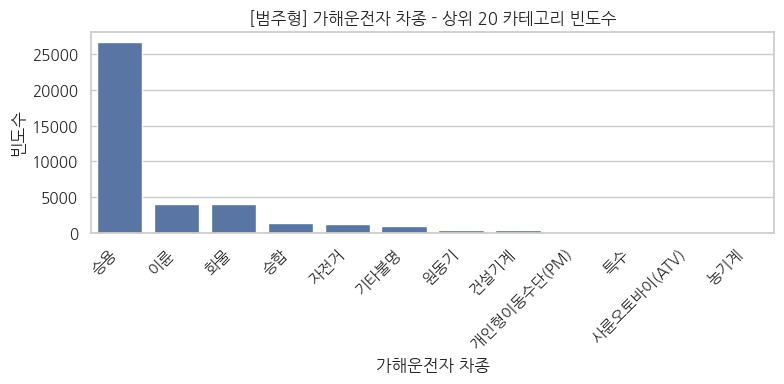

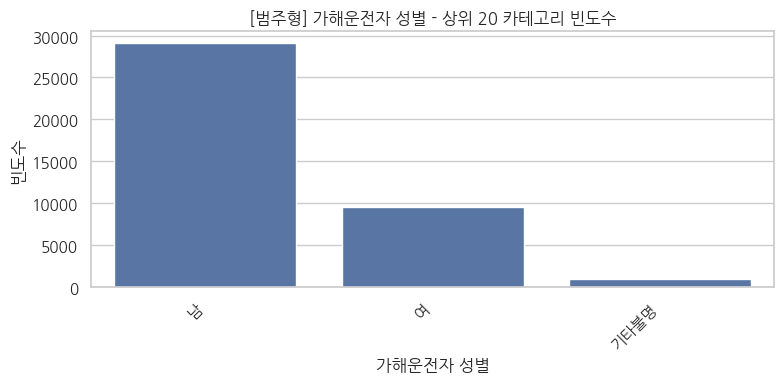

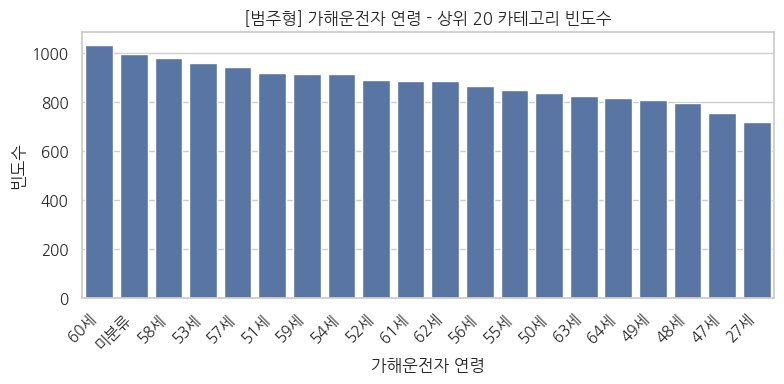

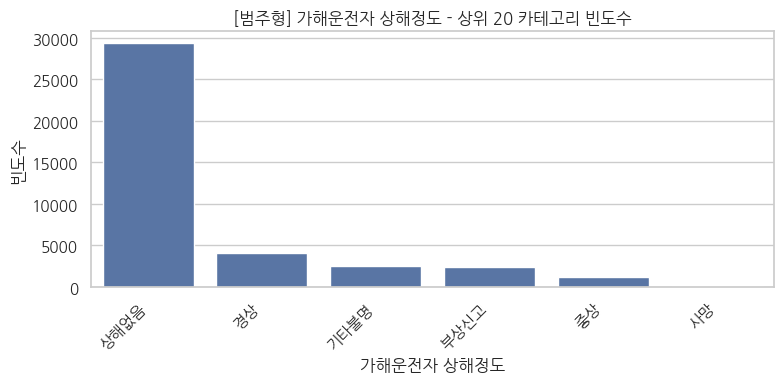

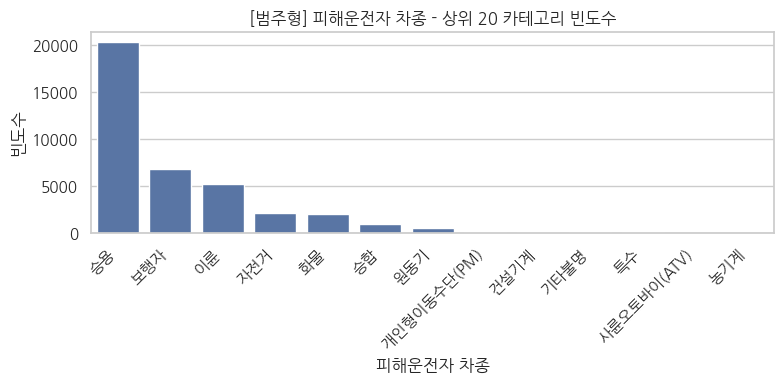

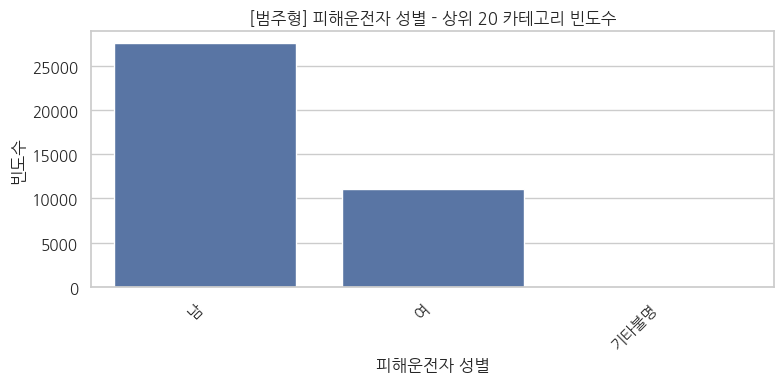

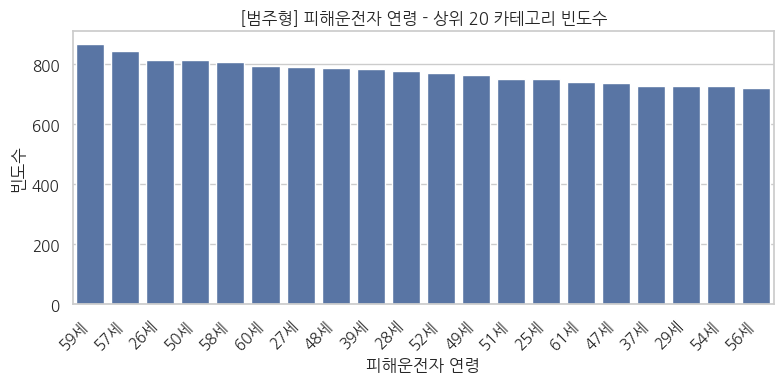

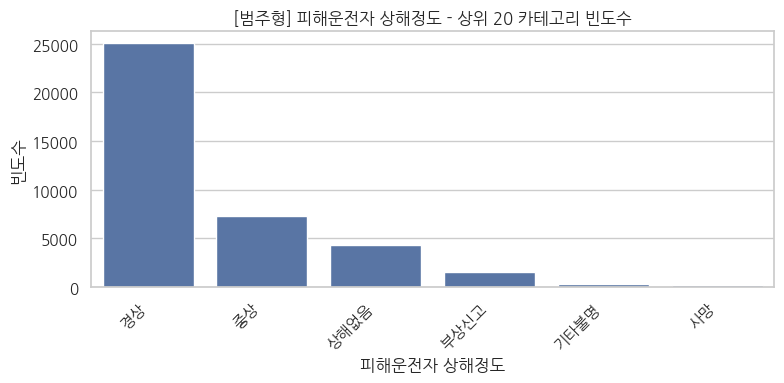

In [ ]:
# ==========================================
# 8. 모든 범주형 컬럼 bar chart 그리기
# ==========================================

TOP_N = 20  # 상위 몇 개 카테고리까지 볼지 설정

if len(categorical_cols) == 0:
    print("범주형 컬럼이 없어 bar chart를 그릴 수 없습니다.")
else:
    for col in categorical_cols:
        # 값 빈도수 계산
        value_counts = df[col].value_counts().head(TOP_N)

        plt.figure(figsize=(8, 4))
        sns.barplot(x=value_counts.index.astype(str),
                    y=value_counts.values)
        plt.title(f"[범주형] {col} - 상위 {TOP_N} 카테고리 빈도수")
        plt.xlabel(col)
        plt.ylabel("빈도수")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


## 9. AI 화면 구현과 다른 점

- train.csv를 스트림릿에 올릴 때엔 세션 스테이터스와 캐시로 관리하자.
- 기차라고 번역되는 것 잘 잡자.